# Bayesian Optimisation of starting Gaussian Process hyperparameters

In [1]:
from pathlib import Path
from shutil import copyfile
import pickle

Data manipulation

In [2]:
import numpy as np
import pandas as pd

Plotting / Visualisation

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 6)

Gaussian Process Regression

In [5]:
import gpflow
import tensorflow as tf

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11949572383101596454]

In [7]:
from gpflow.utilities import print_summary

In [8]:
gpflow.config.set_default_summary_fmt("notebook")

Input scaler:

In [9]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.exceptions import NotFittedError

Bayesian optimisation based on gaussian processes:

## Load previously exported data

In [10]:
dfs_train = []
dfs_test = []

In [11]:
train_exps = ['Exp1', 'Exp3', 'Exp5', 'Exp6']
test_exps = ['Exp2', 'Exp4', 'Exp7']

In [12]:
for exp in train_exps:
    dfs_train.append(pd.read_csv(f"../Data/Good_CARNOT/{exp}_table.csv").rename(columns = {'Power': 'SimulatedHeat'}))
    
for exp in test_exps:
    dfs_test.append(pd.read_csv(f"../Data/Good_CARNOT/{exp}_table.csv").rename(columns = {'Power': 'SimulatedHeat'}))

In [13]:
#t_cols = ['time_h', 'time_m']
t_cols = []
w_cols = ['SolRad', 'OutsideTemp']
u_cols = ['SimulatedHeat']
y_cols = ['SimulatedTemp']

In [14]:
t_lags = 0
w_lags = 1
u_lags = 2
y_lags = 3

In [15]:
dict_cols = {
    't': (t_lags, t_cols),
    'w': (w_lags, w_cols),
    'u': (u_lags, u_cols),
    'y': (y_lags, y_cols)
}

Create the scaler and set up input data scaling:

In [16]:
scaler = MinMaxScaler(feature_range = (-1, 1))

In [17]:
def get_scaled_df(df, dict_cols, scaler):
    
    t_list = dict_cols['t'][1]
    w_list = dict_cols['w'][1]
    u_list = dict_cols['u'][1]
    y_list = dict_cols['y'][1]
    
    df_local = df[t_list + w_list + u_list + y_list]
    df_scaled = df_local.to_numpy()
    
    try:
        df_scaled = scaler.transform(df_scaled)
    except NotFittedError:
        df_scaled = scaler.fit_transform(df_scaled)
        
    df_scaled = pd.DataFrame(df_scaled, index = df_local.index, columns = df_local.columns)
    
    return df_scaled

In [18]:
df_train = pd.concat(dfs_train)

In [19]:
df_train = df_train[t_cols + w_cols + u_cols + y_cols]
df_train.head()

,SolRad,OutsideTemp,SimulatedHeat,SimulatedTemp
0,57.936582,22.0,-31500,23.000000
1,54.914443,22.0,-31500,20.585367
2,73.944706,22.0,-31500,20.300922
3,76.206334,22.0,-31500,20.034647
4,65.120057,22.0,-31500,19.786064


Condition number of the raw input data:

In [20]:
np.linalg.cond(df_train.to_numpy())

16199.169760599052

Fit the scaler and scale the data:

In [21]:
df_train_sc = get_scaled_df(df_train, dict_cols, scaler)

In [22]:
pickle.dump(scaler, open(Path("scaler.pkl"), 'wb'))

Check the condition number of the input data:

In [23]:
np.linalg.cond(df_train_sc.to_numpy())

4.946636675064373

NOTE: Condition number of scaled data is much smaller. This makes sense.

Scale the data for each experiment individually. Used for validation graphs:

In [24]:
dfs_train_sc = []
dfs_test_sc = []
for df in dfs_train:
    df_sc = get_scaled_df(df, dict_cols, scaler)
    dfs_train_sc.append(df_sc)
    
for df in dfs_test:
    df_sc = get_scaled_df(df, dict_cols, scaler)
    dfs_test_sc.append(df_sc)

Set up the function which generated the GPR input matrix from the experimental data (including all autoregressive inputs, etc.):

In [25]:
def data_to_gpr(df, dict_cols):
    
    t_list = dict_cols['t'][1]
    w_list = dict_cols['w'][1]
    u_list = dict_cols['u'][1]
    y_list = dict_cols['y'][1]
    
    df_gpr = df[t_list + w_list + u_list + y_list].copy()
    
    for lags, names in dict_cols.values():
        for name in names:
            col_idx = df_gpr.columns.get_loc(name)
            for lag in range(1, lags + 1):
                df_gpr.insert(col_idx + lag, f"{name}_{lag}", df_gpr.loc[:, name].shift(lag))

    df_gpr.dropna(inplace = True)
    
    return df_gpr

In [26]:
dfs_gpr_train = []
for df_sc in dfs_train_sc:
    dfs_gpr_train.append(data_to_gpr(df_sc, dict_cols))
df_gpr_train = pd.concat(dfs_gpr_train)
df_gpr_train.head()

,SolRad,SolRad_1,OutsideTemp,OutsideTemp_1,SimulatedHeat,SimulatedHeat_1,SimulatedHeat_2,SimulatedTemp,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
3,-0.855164,-0.859463,0.058824,0.058824,-1.0,-1.0,-1.0,-0.295224,-0.270561,-0.244215,-0.020567
4,-0.876235,-0.855164,0.058824,0.058824,-1.0,-1.0,-1.0,-0.318248,-0.295224,-0.270561,-0.244215
5,-0.911207,-0.876235,0.058824,0.058824,-1.0,-1.0,-1.0,-0.340062,-0.318248,-0.295224,-0.270561
6,-0.933425,-0.911207,0.058824,0.058824,1.0,-1.0,-1.0,-0.361066,-0.340062,-0.318248,-0.295224
7,-0.952322,-0.933425,0.058824,0.058824,-1.0,1.0,-1.0,0.051533,-0.361066,-0.340062,-0.318248


In [27]:
df_gpr_train = df_gpr_train.sample(n = 500)

In [28]:
dfs_gpr_test = []
for df_sc in dfs_test_sc:
    dfs_gpr_test.append(data_to_gpr(df_sc, dict_cols))

In [29]:
df_input_train = df_gpr_train.drop(columns = dict_cols['w'][1] + dict_cols['u'][1] + dict_cols['y'][1])
df_output_train = df_gpr_train[dict_cols['y'][1]]

np_input_train = df_input_train.to_numpy()
np_output_train = df_output_train.to_numpy().reshape(-1, 1)

In [30]:
data_train = (np_input_train, np_output_train)
#pickle.dump(data_train, open(Path("data_train.pkl"), 'wb'))

In [31]:
df_input_train.head()

,SolRad_1,OutsideTemp_1,SimulatedHeat_1,SimulatedHeat_2,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
300,-0.974464,0.176471,1.0,1.0,0.326189,-0.087420,0.321339
480,-0.777500,0.176471,-1.0,-1.0,-0.084498,-0.059295,0.355899
515,-0.553813,-0.647059,-1.0,-1.0,-0.865533,-0.846006,-0.826211
59,-0.994317,-0.294118,1.0,-1.0,-0.564532,-0.153945,-0.566251
521,-0.519473,-0.647059,1.0,-1.0,-0.925709,-0.909629,-0.893742


In [32]:
## Define Kernel

In [33]:
nb_dims = np_input_train.shape[1]
rational_dims = np.arange(0, (dict_cols['t'][0] + 1) * len(dict_cols['t'][1]), 1)
nb_rational_dims = len(rational_dims)
squared_dims = np.arange(nb_rational_dims, nb_dims, 1)
nb_squared_dims = len(squared_dims)

In [34]:
print(f"rational: {nb_rational_dims}")
print(f"squared: {nb_squared_dims}")

rational: 0
squared: 7


In [35]:
squared_l = np.linspace(1, 1, nb_squared_dims)
rational_l = np.linspace(1, 1, nb_rational_dims)

In [36]:
variance = tf.math.reduce_variance(np_input_train)

In [37]:
k0 = gpflow.kernels.SquaredExponential(lengthscales = squared_l, active_dims = squared_dims, variance = variance)
k1 = gpflow.kernels.Constant(variance = variance)
k2 = gpflow.kernels.RationalQuadratic(lengthscales = rational_l, active_dims = rational_dims, variance = variance)
k3 = gpflow.kernels.Periodic(k2)

In [38]:
k = (k0 + k1) * k2
k = k0
print_summary(k)

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,0.4604227545301106
SquaredExponential.lengthscales,Parameter,Softplus,,True,"(7,)",float64,"[1., 1., 1...."


## Compile Model

In [39]:
m = gpflow.models.GPR(
    data = data_train, 
    kernel = k, 
    mean_function = None,
    )
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.4604227545301106
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(7,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


In [40]:
#m.likelihood.variance.assign(0.5)

In [41]:
#gpflow.set_trainable(m.likelihood.variance, False)

## Train Model

In [42]:
opt = gpflow.optimizers.Scipy()

In [43]:
from datetime import datetime

In [44]:
start_time = datetime.now()
opt.minimize(m.training_loss, m.trainable_variables)
print(f"Finished fitting in {datetime.now() - start_time}")
print_summary(m)

Finished fitting in 0:00:02.662818


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.614448011499247
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(7,)",float64,"[2.09687221, 2.83126912, 8.24983556..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1e-06


Export model parameters:

In [45]:
pickle.dump(m, open(Path('gp_model.pkl'), 'wb'))
pickle.dump(dict_cols, open(Path('dict_cols.pkl'), 'wb'))

## Evaluate performance on training data

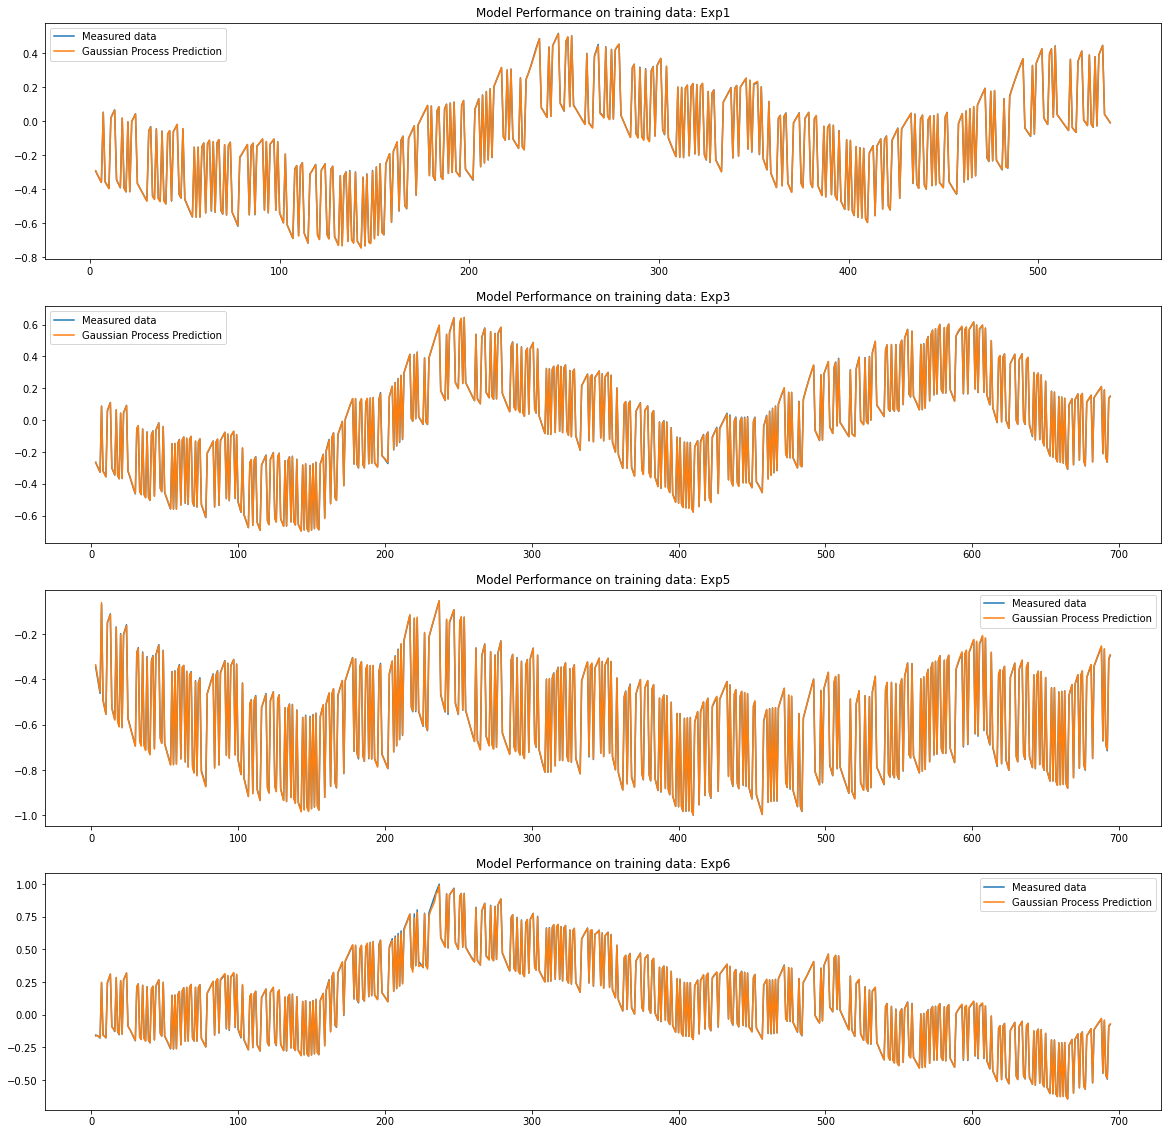

In [46]:
nb_plts = len(dfs_train)

plt.figure(figsize = (20, 20))

for idx, df_iter in enumerate(dfs_gpr_train):
    plt.subplot(nb_plts, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = dict_cols['w'][1] + dict_cols['y'][1] + dict_cols['u'][1])
    df_output_iter = df_iter[dict_cols['y'][1]]
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m.predict_f(np_input_iter)
    
    plt.plot(df_iter.index, np_output_iter[:, :], label = 'Measured data')
    plt.plot(df_iter.index, mean[:, :], label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    plt.title(f"Model Performance on training data: {train_exps[idx]}")
    plt.legend()
plt.savefig(f"Performance_train_exps.png")

## Evaluate performance on test data

In [47]:
def SMSE(measured, predicted):
    N = measured.size
    measured_var = np.var(measured)
    SMSE = np.power(measured - predicted, 2).sum()/(N*measured_var)
    return SMSE

In [48]:
def RMSE(measured, predicted):
    N = measured.size
    RMSE = np.sqrt(np.power(measured - predicted, 2).sum()/N)
    return RMSE

In [49]:
def LPD(measured, predicted_mean, predicted_var):
    N = measured.size
    sum_part = np.log(predicted_var) + np.power(measured - predicted_mean, 2)/predicted_var
    LPD = 1/2*np.log(2*np.pi) + 1/(2*N)*sum_part.sum()
    return LPD

In [50]:
def MSLL(measured, predicted_mean, predicted_var):
    measured_var = np.var(measured)
    measured_mean = np.mean(measured)
    return LPD(measured, predicted_mean, predicted_var) - LPD(measured, measured_mean, measured_var)

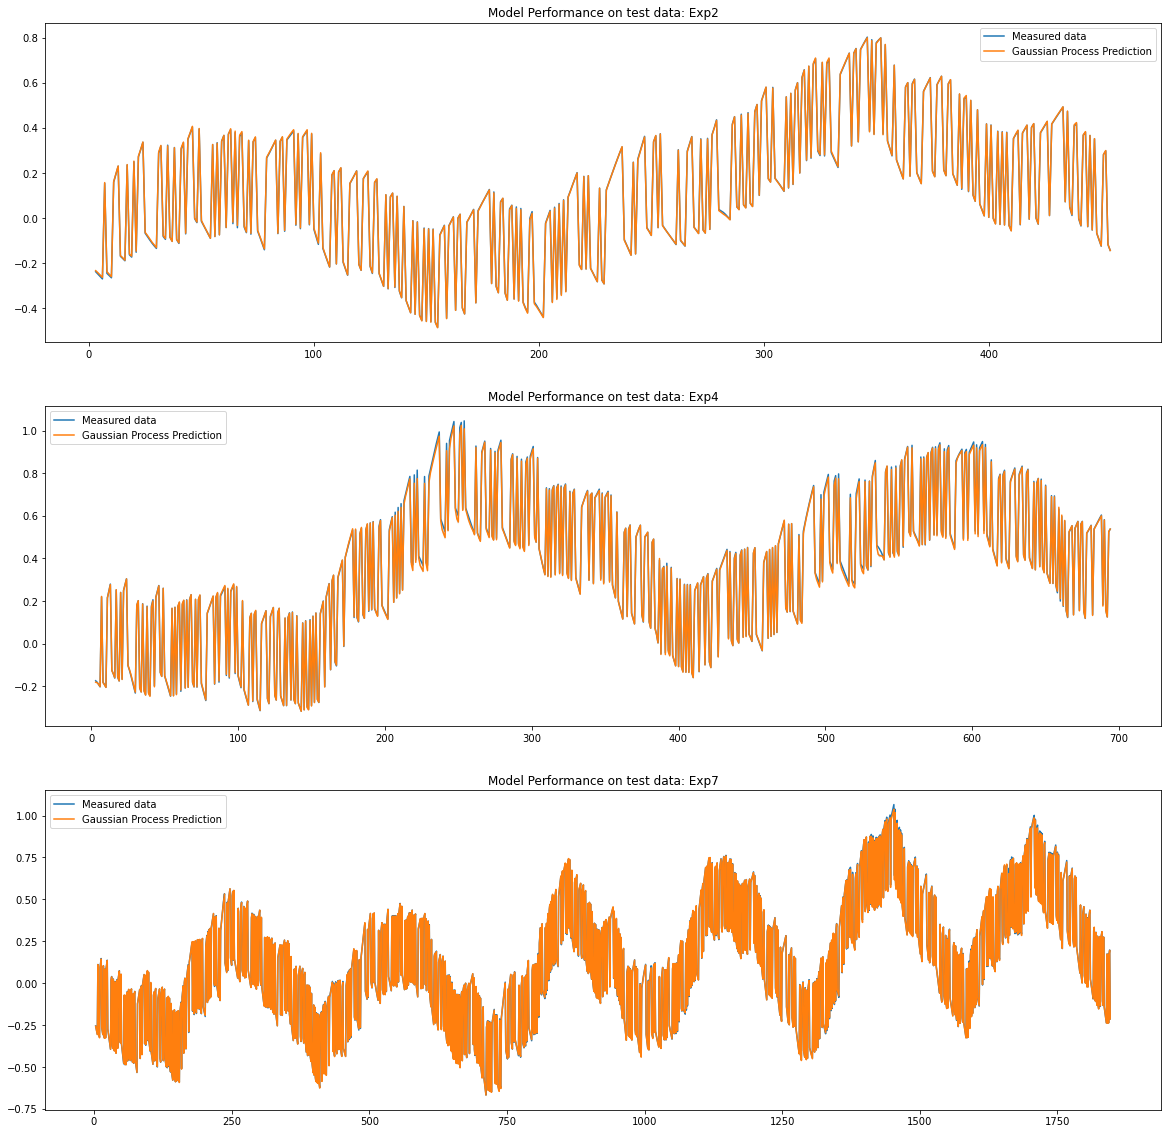

In [51]:
nb_plts = len(dfs_test)

test_smse = 0
test_rmse = 0
test_lpd = 0
test_msll = 0

plt.figure(figsize = (20, 20))

for idx, df_iter in enumerate(dfs_gpr_test):
    plt.subplot(nb_plts, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = dict_cols['w'][1] + dict_cols['y'][1] + dict_cols['u'][1])
    df_output_iter = df_iter[dict_cols['y'][1]]
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m.predict_f(np_input_iter)
    
    test_smse += SMSE(np_output_iter, mean.numpy())
    test_rmse += RMSE(np_output_iter, mean.numpy())
    test_lpd += LPD(np_output_iter, mean.numpy(), var.numpy())
    test_msll += MSLL(np_output_iter, mean.numpy(), var.numpy())

    
    plt.plot(df_iter.index, np_output_iter[:, :], label = 'Measured data')
    plt.plot(df_iter.index, mean[:, :], label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    plt.title(f"Model Performance on test data: {test_exps[idx]}")
    plt.legend()
plt.savefig(f"Performance_test_exps.png")

## Multistep prediction

In [52]:
df_input = dfs_gpr_train[0].drop(columns = dict_cols['w'][1] + dict_cols['u'][1] + dict_cols['y'][1])
df_output = dfs_gpr_train[0][dict_cols['y'][1]]

In [53]:
start_idx = 25
nb_predictions = 25
N_pred = 20

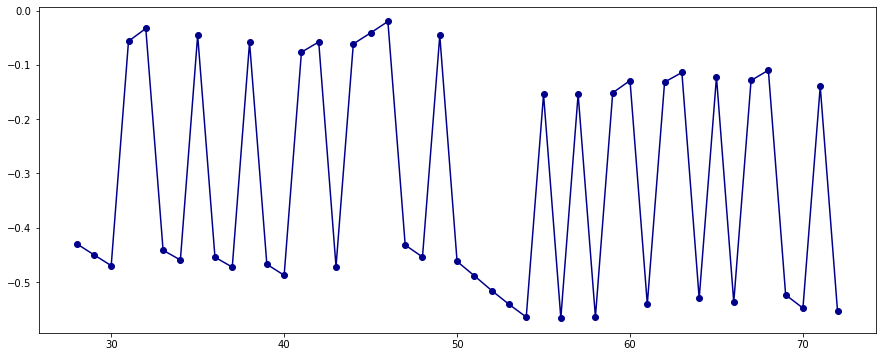

In [54]:
plt.figure()
plt.plot(df_output.iloc[start_idx:start_idx + nb_predictions + N_pred], 'o-', label = 'measured', color = 'darkblue')

In [55]:
df_iter

,SolRad,SolRad_1,OutsideTemp,OutsideTemp_1,SimulatedHeat,SimulatedHeat_1,SimulatedHeat_2,SimulatedTemp,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
3,-0.828499,-0.686753,0.294118,0.294118,-1.0,-1.0,-1.0,-0.255370,-0.240796,-0.227086,-0.020567
4,-0.858285,-0.828499,0.294118,0.294118,-1.0,-1.0,-1.0,-0.270921,-0.255370,-0.240796,-0.227086
5,-0.866567,-0.858285,0.294118,0.294118,-1.0,-1.0,-1.0,-0.287999,-0.270921,-0.255370,-0.240796
6,-0.864584,-0.866567,0.294118,0.294118,1.0,-1.0,-1.0,-0.305151,-0.287999,-0.270921,-0.255370
7,-0.811292,-0.864584,0.294118,0.294118,-1.0,1.0,-1.0,0.111516,-0.305151,-0.287999,-0.270921
...,...,...,...,...,...,...,...,...,...,...,...
1842,-0.993804,-0.994013,0.058824,0.058824,-1.0,1.0,-1.0,0.174022,-0.238089,0.173677,-0.236739
1843,-0.993823,-0.993804,0.058824,0.058824,1.0,-1.0,1.0,-0.236873,0.174022,-0.238089,0.173677
1844,-0.993842,-0.993823,0.058824,0.058824,1.0,1.0,-1.0,0.175584,-0.236873,0.174022,-0.238089
1845,-0.993652,-0.993842,0.058824,0.058824,-1.0,1.0,1.0,0.197791,0.175584,-0.236873,0.174022


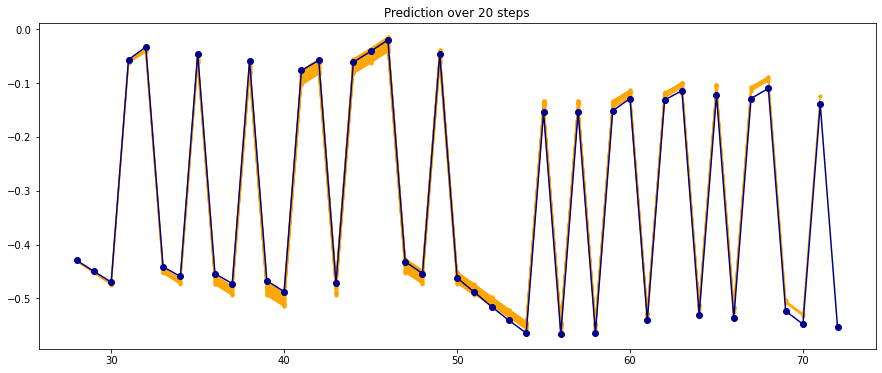

In [56]:
plt.figure()

y_name = dict_cols['y'][1][0]
for idx in range(start_idx, start_idx + nb_predictions):
    df_iter = df_input.iloc[idx:(idx + N_pred)].copy()
    for idxx in range(N_pred - 1):
        idx_old = df_iter.index[idxx]
        idx_new = df_iter.index[idxx+1]
        mean, var = m.predict_f(df_iter.loc[idx_old, :].to_numpy().reshape(1, -1))
        df_iter.loc[idx_new, f'{y_name}_1'] = mean.numpy().flatten()
        for lag in range(2, dict_cols['y'][0] + 1):
            df_iter.loc[idx_new, f"{y_name}_{lag}"] = df_iter.loc[idx_old, f"{y_name}_{lag-1}"]
        
    mean_iter, var_iter = m.predict_f(df_iter.to_numpy())
    plt.plot(df_iter.index, mean_iter.numpy(), '.-', label = 'predicted', color = 'orange')
plt.plot(df_output.iloc[start_idx:start_idx + nb_predictions + N_pred], 'o-', label = 'measured', color = 'darkblue')
plt.title(f"Prediction over {N_pred} steps")
plt.savefig(f"prediction_{N_pred}_steps.png")

## Test CasADi problem

In [57]:
import casadi as cs

In [58]:
class GPR(cs.Callback):
    def __init__(self, name, model, opts={}):
        cs.Callback.__init__(self)

        self.model = model
        self.n_in = model.data[0].shape[1]
        # Create a variable to keep all the gradient callback references
        self.refs = []

        self.construct(name, opts)
    
    # Number of inputs/outputs
    def get_n_in(self): return 1
    def get_n_out(self): return 1
    

    # Sparsity of the input/output
    def get_sparsity_in(self,i):
        return cs.Sparsity.dense(1,self.n_in)
    def get_sparsity_out(self,i):
        return cs.Sparsity.dense(1,1)


    def eval(self, arg):
        inp = np.array(arg[0])
        inp = tf.Variable(inp, dtype=tf.float64)
        [mean, _] = self.model.predict_f(inp)
        return [mean.numpy()]
    
    def has_reverse(self, nadj): return nadj==1
    def get_reverse(self, nadj, name, inames, onames, opts):
        grad_callback = GPR_grad(name, self.model)
        self.refs.append(grad_callback)
        
        nominal_in = self.mx_in()
        nominal_out = self.mx_out()
        adj_seed = self.mx_out()
        return cs.Function(name, nominal_in+nominal_out+adj_seed, grad_callback.call(nominal_in), inames, onames)
        
class GPR_grad(cs.Callback):
    def __init__(self, name, model, opts={}):
        cs.Callback.__init__(self)  
        self.model = model
        self.n_in = model.data[0].shape[1]

        self.construct(name, opts)

    
    def get_n_in(self): return 1
    def get_n_out(self): return 1
    
    def get_sparsity_in(self,i):
        return cs.Sparsity.dense(1,self.n_in)
    def get_sparsity_out(self,i):
        return cs.Sparsity.dense(1,self.n_in)


    def eval(self, arg):
        inp = np.array(arg[0])
        inp = tf.Variable(inp, dtype=tf.float64)
        
        with tf.GradientTape() as tape:
            preds = self.model.predict_f(inp)

        grads = tape.gradient(preds, inp)
        return [grads.numpy()]

In [59]:
cs_model = GPR("gpr", m)

In [60]:
N_horizon = 5;

T_set = 23;
T_set_sc = scaler.transform(np.array([0, 0, 0, T_set]).reshape(1, -1))[0, 3]
n_states = m.data[0].shape[1]

In [61]:
total_cols = 0
for lags, cols in dict_cols.values():
    total_cols += lags*(len(cols)+1)
total_cols = total_cols -2
print(total_cols)

11


In [62]:
W = cs.MX.sym("W", N_horizon, 2)
U = cs.MX.sym("U", N_horizon, 1)
x0 = cs.MX.sym("x0", 1, n_states)
Xk = cs.MX.sym("Xk", 0, n_states)

In [63]:
yhats = cs.MX.sym("yhats", 0, 1)

In [64]:
yhat = cs_model(x0)

In [65]:
yhats = cs.vertcat(yhats, yhat)

### First step

In [66]:
xk = x0

### All the other steps

In [67]:
for row_idx in range(N_horizon):
    # w
    base_idx = 0
    nb_cols = len(dict_cols['w'][1])*(dict_cols['w'][0])
    wk_1 = xk[base_idx:base_idx + nb_cols]
    
    wk = cs.MX.sym("wk", 1, 0)
    nb_lags = dict_cols['w'][0]

    for idx in range(W.shape[1]):
        base_col = idx * (nb_lags - 1)
        wk = cs.horzcat(wk, W[row_idx, idx], wk_1[base_col:base_col + nb_lags - 1])
        
    # u
    base_idx += nb_cols
    nb_cols = len(dict_cols['u'][1])*dict_cols['u'][0]
    uk_1 = xk[base_idx:base_idx + nb_cols]

    
    nb_lags = dict_cols['u'][0] - 1
    uk = cs.horzcat(U[row_idx], uk_1[:nb_lags])
    
    # y
    base_idx += nb_cols
    nb_cols = len(dict_cols['y'][1])*dict_cols['y'][0]
    yk_1 = xk[base_idx: base_idx + nb_cols]
    
    nb_lags = dict_cols['y'][0] - 1
    yk = cs.horzcat(yhat, yk_1[:nb_lags])
    
    xk = cs.horzcat(wk, uk, yk)
    Xk = cs.vertcat(Xk, xk)
    yhat = cs_model(xk)
    yhats = cs.vertcat(yhats, yhat)


Helper functions to easily reproduce everything:

In [68]:
ff = cs.Function('ff', [W, U, x0], [yhats])

In [69]:
Ff = cs.Function('Ff', [W, U, x0], [Xk])

Compute the objective function:

In [70]:
y_diff = yhats - T_set_sc
J = cs.dot(y_diff, y_diff)

Compute the parameters vector:

In [71]:
p = cs.vertcat(cs.vec(W), cs.vec(x0))

In [72]:
prob = {"x": cs.vec(U), "f": J, "p": p}
options = {"ipopt": {"hessian_approximation": "limited-memory", "max_cpu_time": 500,
                    "acceptable_tol": 1e-8, "acceptable_obj_change_tol": 1e-6}}

In [73]:
solver = cs.nlpsol("solver","ipopt",prob, options)

Check the functions on "real" values

In [74]:
real_W = np.random.rand(*W.shape)
real_U = np.random.rand(*U.shape).reshape(-1, 1)
real_x0 = np.random.rand(*x0.shape).reshape(1, -1)

In [75]:
yhats_ff = ff(real_W, real_U, real_x0)
np.array(yhats_ff)

array([[0.32890961],
       [0.4927122 ],
       [0.49099943],
       [0.39245806],
       [0.46950959],
       [0.43129113]])

In [76]:
Xk_Ff = Ff(real_W, real_U, real_x0)
pd.DataFrame(np.array(Xk_Ff), columns = df_input_train.columns)

,SolRad_1,OutsideTemp_1,SimulatedHeat_1,SimulatedHeat_2,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
0,0.895049,0.607689,0.861179,0.163126,0.328910,0.357209,0.823767
1,0.526683,0.921205,0.671148,0.861179,0.492712,0.328910,0.357209
2,0.122918,0.763526,0.036916,0.671148,0.490999,0.492712,0.328910
3,0.229133,0.133035,0.337802,0.036916,0.392458,0.490999,0.492712
4,0.128558,0.819764,0.010466,0.337802,0.469510,0.392458,0.490999


In [77]:
np_realxk = np.empty((N_horizon + 1, n_states))
np_realxk[0, :] =  real_x0
np_realxk[1:, :2] =  real_W
np_realxk[1:, 2] =  real_U.ravel()

for row_idx in range(N_horizon):
    mean, _ = m.predict_f(np_realxk[row_idx, :].reshape(1, -1))
    np_realxk[row_idx + 1, 3] = np_realxk[row_idx, 2]
    np_realxk[row_idx + 1, 4] = mean
    np_realxk[row_idx + 1, 5] = np_realxk[row_idx, 4]
    np_realxk[row_idx + 1, 6] = np_realxk[row_idx, 5]
np_yhats, _ = m.predict_f(np_realxk)
np_yhats

<tf.Tensor: shape=(6, 1), dtype=float64, numpy=
array([[0.32890961],
       [0.4927122 ],
       [0.49099943],
       [0.39245806],
       [0.46950959],
       [0.43129113]])>

In [78]:
yhats_ff - np_yhats

<tf.Tensor: shape=(6, 1), dtype=float64, numpy=
array([[ 4.73010520e-13],
       [ 3.35148576e-12],
       [-2.21855867e-12],
       [-1.00047748e-12],
       [ 2.40901743e-12],
       [ 5.94191363e-13]])>

In [79]:
mean, _ = m.predict_f(np_realxk[2,:].reshape(1, -1))
mean

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.49099943]])>

### Set up the problem and solve it

In [80]:
start_idx = 25
test_gpr = data_to_gpr(dfs_test_sc[0], dict_cols).drop(columns = u_cols + y_cols)
real_x0 = cs.DM(test_gpr.iloc[start_idx, :].to_numpy())
real_W0 = cs.DM(test_gpr.iloc[start_idx + 1: start_idx + N_horizon, :2].to_numpy())

In [81]:
real_p = cs.vertcat(cs.vec(real_W0), cs.vec(real_x0))

In [82]:
test_gpr.iloc[start_idx: start_idx + N_horizon + 1]

,SolRad,SolRad_1,OutsideTemp,OutsideTemp_1,SimulatedHeat_1,SimulatedHeat_2,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
28,-0.212505,-0.187772,0.529412,0.470588,-1.0,-1.0,-0.096638,-0.081987,-0.067024
29,-0.238686,-0.212505,0.529412,0.529412,-1.0,-1.0,-0.110607,-0.096638,-0.081987
30,-0.266314,-0.238686,0.529412,0.529412,-1.0,-1.0,-0.123156,-0.110607,-0.096638
31,-0.293791,-0.266314,0.529412,0.529412,1.0,-1.0,-0.134641,-0.123156,-0.110607
32,-0.319120,-0.293791,0.529412,0.529412,1.0,1.0,0.287059,-0.134641,-0.123156
33,-0.438859,-0.319120,0.529412,0.529412,-1.0,1.0,0.319561,0.287059,-0.134641


In [83]:
res = solver(lbx = -1, ubx = 1, p = real_p, x0 = -1)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        5
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constrain

Exception ignored in: <bound method WeakStructRef._cleanup of WeakStructRef(HashableWeakRef(<weakref at 0x7f0448f557c0; dead>))>
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/tensorflow_probability/python/internal/cache_util.py", line 153, in _cleanup
    if self._alive:
AttributeError: _alive
2021-05-22 10:38:28 WARNING("solver:nlp_f failed:Error in Function::operator() for 'nlp_f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'gpr' [CallbackInternal] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for gpr:
.../casadi/core/callback_internal.cpp:122: Error calling "eval" for object gpr:
KeyboardInterrupt") [.../casadi/core/oracle_function.cpp:223]
CasADi - 2021-05-22 10:38:28 WARNING("solver:nlp_f failed:Error in Function::operator() for 'nlp_f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'gpr' [CallbackInternal] at

  12  1.4931699e-01 0.00e+00 8.82e-03  -5.6 3.36e-02    -  1.00e+00 1.61e-15f 50


CasADi - 2021-05-22 10:38:33 WARNING("solver:nlp_f failed:Error in Function::operator() for 'nlp_f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'gpr' [CallbackInternal] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for gpr:
.../casadi/core/callback_internal.cpp:122: Error calling "eval" for object gpr:
KeyboardInterrupt") [.../casadi/core/oracle_function.cpp:223]


Exception ignored in: <bound method WeakStructRef._cleanup of WeakStructRef(HashableWeakRef(<weakref at 0x7f0448f6e220; dead>))>
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/tensorflow_probability/python/internal/cache_util.py", line 153, in _cleanup
    if self._alive:
AttributeError: _alive


  13  1.4931699e-01 0.00e+00 1.27e-02  -5.6 1.27e-02    -  1.00e+00 3.54e-15f 49


CasADi - 2021-05-22 10:38:34 WARNING("solver:nlp_f failed:Error in Function::operator() for 'nlp_f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'gpr' [CallbackInternal] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for gpr:
.../casadi/core/callback_internal.cpp:122: Error calling "eval" for object gpr:
KeyboardInterrupt") [.../casadi/core/oracle_function.cpp:223]
CasADi - 2021-05-22 10:38:35 WARNING("solver:nlp_f failed:Error in Function::operator() for 'nlp_f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'gpr' [CallbackInternal] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for gpr:
.../casadi/core/callback_internal.cpp:122: Error calling "eval" for object gpr:
KeyboardInterrupt") [.../casadi/core/oracle_function.cpp:223]


CasADi - 2021-05-22 10:38:36 WARNING("solver:nlp_f failed:Error in Function::operator() for 'nlp_f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'gpr' [CallbackInternal] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for gpr:
.../casadi/core/callback_internal.cpp:122: Error calling "eval" for object gpr:
KeyboardInterrupt") [.../casadi/core/oracle_function.cpp:223]


CasADi - 2021-05-22 10:38:37 WARNING("solver:nlp_f failed:Error in Function::operator() for 'nlp_f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'gpr' [CallbackInternal] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for gpr:
.../casadi/core/callback_internal.cpp:122: Error calling "eval" for object gpr:
KeyboardInterrupt") [.../casadi/core/oracle_function.cpp:223]


CasADi - 2021-05-22 10:38:37 WARNING("solver:nlp_f failed:Error in Function::operator() for 'nlp_f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'gpr' [CallbackInternal] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for gpr:
.../casadi/core/callback_internal.cpp:122: Error calling "eval" for object gpr:
KeyboardInterrupt") [.../casadi/core/oracle_function.cpp:223]


CasADi - 2021-05-22 10:38:38 WARNING("solver:nlp_grad_f failed:Error in Function::operator() for 'nlp_grad_f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'adj1_gpr' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'adj1_gpr' [CallbackInternal] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for adj1_gpr:
.../casadi/core/callback_internal.cpp:122: Error calling "eval" for object adj1_gpr:
KeyboardInterrupt") [.../casadi/core/oracle_function.cpp:223]



Number of Iterations....: 14

Number of objective function evaluations             = 578
Number of objective gradient evaluations             = 15
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total CPU secs in IPOPT (w/o function evaluations)   =      0.863
Total CPU secs in NLP function evaluations           =     92.025

EXIT: Invalid number in NLP function or derivative detected.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  81.63 s (141.22ms)  45.29 s ( 78.36ms)       578
    nlp_grad  |   1.33 s (  1.33 s) 445.02ms (445.02ms)         1
  nlp_grad_f  |  12.81 s (800.63ms)   4.56 s (284.76ms)        16
       total  |  95.80 s ( 95.80 s)  50.33 s ( 50.33 s)         1


CasADi - 2021-05-22 10:38:38 WARNING("solver:nlp_grad failed:Error in Function::operator() for 'nlp_grad' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'adj1_gpr' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'adj1_gpr' [CallbackInternal] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for adj1_gpr:
.../casadi/core/callback_internal.cpp:122: Error calling "eval" for object adj1_gpr:
KeyboardInterrupt") [.../casadi/core/oracle_function.cpp:223]
CasADi - 2021-05-22 10:38:38 WARNING("Failed to calculate multipliers") [.../casadi/core/nlpsol.cpp:621]


In [84]:
res['x']

DM([-0.977191, -0.975261, -0.971324, -0.969565, -0.997771])

In [85]:
Ff(real_W, np.ones((N_horizon, 1)), real_x0)

RuntimeError: .../casadi/core/function_internal.hpp:1257: Input 2 (i2) has mismatching shape. Got 9-by-1. Allowed dimensions, in general, are:
 - The input dimension N-by-M (here 1-by-7)
 - A scalar, i.e. 1-by-1
 - M-by-N if N=1 or M=1 (i.e. a transposed vector)
 - N-by-M1 if K*M1=M for some K (argument repeated horizontally)
 - N-by-P*M, indicating evaluation with multiple arguments (P must be a multiple of 1 for consistency with previous inputs)

In [ ]:
Ff(real_W, res['x'], real_x0)

In [ ]:
cs.norm_2(ff(real_W, np.ones((N_horizon, 1)), real_x0) - T_set_sc)

In [ ]:
cs.norm_2(ff(real_W, res['x'], real_x0) - T_set_sc)

In [ ]:
T_set

### Multiple shooting problem formulation

In [212]:
N_horizon = 15

In [213]:
X = cs.MX.sym("X", N_horizon + 1, n_states)
lbd = cs.MX.sym("lambda")
x0 = cs.MX.sym("x0", 1, n_states)
W = cs.MX.sym("W", N_horizon, 2)

In [214]:
g = []
lbg = []
ubg = []

lbx = -np.inf*np.ones(X.shape)
ubx = np.inf*np.ones(X.shape)

T_set_sc = 2.5
##
# Set up the opjective function
##

# stage cost
u_cost = cs.dot(X[:, 2], X[:, 2])

# temperature constraint
y_cost = 0.01 * cs.dot(X[:, 4], X[:, 4])

J = u_cost + y_cost

In [215]:
# Set up equality constraints for the first step
for idx in range(n_states):
    g.append(X[0, idx] - x0[0, idx])
    lbg.append(0)
    ubg.append(0)

In [216]:
# Set up equality constraints for the following steps
for idx in range(1, N_horizon + 1):
    base_col = 0
    # w
    nb_cols = dict_cols['w'][0]
    for w_idx in range(W.shape[1]):
        w_base_col = w_idx * nb_cols
        g.append(X[idx, base_col + w_base_col] - W[idx - 1, w_idx])
        lbg.append(0)
        ubg.append(0)
        for w_lag_idx in range(1, nb_cols):
            g.append(X[idx, base_col + w_base_col + w_lag_idx] - X[idx - 1, base_col + w_base_col + w_lag_idx - 1])
            lbg.append(0)
            ubg.append(0)
            
    base_col += nb_cols * W.shape[1]
    # u
    nb_cols = dict_cols['u'][0]

    lbx[idx, base_col] = -1 #lower bound on input
    ubx[idx, base_col] = 1 #upper bound on input
    for u_lag_idx in range(1, nb_cols):
        g.append(X[idx, base_col + u_lag_idx] - X[idx - 1, base_col + u_lag_idx - 1])
        lbg.append(0)
        ubg.append(0)
    
    base_col += nb_cols
    # y
    nb_cols = dict_cols['y'][0]
    g.append(X[idx, base_col] - cs_model(X[idx - 1, :]))
    lbg.append(0)
    ubg.append(0)
    for y_lag_idx in range(1, nb_cols):
        g.append(X[idx, base_col + y_lag_idx] - X[idx - 1, base_col + y_lag_idx - 1])
        lbg.append(0)
        ubg.append(0)

In [217]:
p = cs.vertcat(cs.vec(W), cs.vec(x0))

In [218]:
prob = {'f': J, 'x': cs.vec(X), 'g': cs.vertcat(*g), 'p': p}
options = {"ipopt": {"hessian_approximation": "limited-memory", "max_iter": 100,
                     #"acceptable_tol": 1e-6, "tol": 1e-6,
                     "linear_solver": "ma97",
                     #"acceptable_obj_change_tol": 1e-5, 
                     #"mu_strategy": "adaptive",
                    }}
solver = cs.nlpsol("solver","ipopt",prob, options)

In [219]:
real_x0 = np.random.rand(*x0.shape)
real_x0

array([[0.86012651, 0.95626129, 0.45825487, 0.22661711, 0.18875246,
        0.37888797, 0.50460262]])

In [220]:
real_W = np.random.rand(*W.shape)
real_W

array([[0.99500505, 0.98441887],
       [0.97592386, 0.84418797],
       [0.71078995, 0.60759562],
       [0.8453497 , 0.90601194],
       [0.61088361, 0.22822987],
       [0.4715091 , 0.63980811],
       [0.86056876, 0.94931176],
       [0.68535098, 0.09049112],
       [0.47124395, 0.71801702],
       [0.70271526, 0.24253517],
       [0.90092676, 0.22352921],
       [0.10499574, 0.93066614],
       [0.94354965, 0.88045902],
       [0.27451341, 0.73862172],
       [0.26057742, 0.82322702]])

In [221]:
real_p = cs.vertcat(cs.vec(real_W), cs.vec(real_x0))

In [222]:
res = solver(lbx = cs.vec(lbx), ubx = cs.vec(ubx), p = real_p, lbg = lbg, ubg = ubg)

This is Ipopt version 3.13.4, running with linear solver ma97.

Number of nonzeros in equality constraint Jacobian...:      247
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      112
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       15
                     variables with only upper bounds:        0
Total number of equality constraints.................:       97
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.95e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1

In [117]:
np_res = np.array(res['x'].reshape(X.shape))
pd.DataFrame(np_res, columns = df_input.columns)

,SolRad_1,OutsideTemp_1,SimulatedHeat_1,SimulatedHeat_2,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
0,0.933665,0.530151,0.668810,0.067268,0.210537,0.229176,0.102786
1,0.771653,0.409330,1.000000,0.668810,0.357439,0.210537,0.229176
2,0.766266,0.790886,1.000000,1.000000,0.454808,0.357439,0.210537
3,0.498328,0.239956,1.000000,1.000000,0.485466,0.454808,0.357439
4,0.834280,0.630368,1.000000,1.000000,0.515284,0.485466,0.454808
5,0.543126,0.862253,1.000000,1.000000,0.537800,0.515284,0.485466
6,0.470207,0.194792,1.000000,1.000000,0.572859,0.537800,0.515284
7,0.593612,0.656472,1.000000,1.000000,0.600478,0.572859,0.537800
8,0.010641,0.183945,1.000000,1.000000,0.628839,0.600478,0.572859
9,0.704691,0.324476,1.000000,1.000000,0.647787,0.628839,0.600478


In [ ]:
mean, var = m.predict_f(np_res)

In [ ]:
mean